# Handwritten Formula (HWF)

This notebook shows an implementation of [Handwritten Formula](https://arxiv.org/abs/2006.06649). In this task, handwritten images of decimal formulas and their computed results are given, alongwith a domain knowledge base containing information on how to compute the decimal formula. The task is to recognize the symbols (which can be digits or operators '+', '-', '×', '÷') of handwritten images and accurately determine their results.

Intuitively, we first use a machine learning model (learning part) to convert the input images to symbols (we call them pseudo-labels), and then use the knowledge base (reasoning part) to calculate the results of these symbols. Since we do not have ground-truth of the symbols, in Abductive Learning, the reasoning part will leverage domain knowledge and revise the initial symbols yielded by the learning part through abductive reasoning. This process enables us to further update the machine learning model.

In [1]:
# Import necessary libraries and modules
import os.path as osp
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from examples.hwf.datasets import get_dataset
from examples.models.nn import SymbolNet
from abl.learning import ABLModel, BasicNN
from abl.reasoning import KBBase, Reasoner
from abl.evaluation import ReasoningMetric, SymbolMetric
from abl.utils import ABLLogger, print_log
from abl.bridge import SimpleBridge

## Working with Data

First, we get the training and testing datasets:

In [2]:
train_data = get_dataset(train=True, get_pseudo_label=True)
test_data = get_dataset(train=False, get_pseudo_label=True)

Both `train_data` and `test_data` have the same structures: tuples with three components: X (list where each element is a list of images), gt_pseudo_label (list where each element is a list of symbols, i.e., pseudo-labels) and Y (list where each element is the computed result). The length and structures of datasets are illustrated as follows.

Note: ``gt_pseudo_label`` is only used to evaluate the performance of the learning part but not to train the model.

In [3]:
print(f"Both train_data and test_data consist of 3 components: X, gt_pseudo_label, Y")
print()
train_X, train_gt_pseudo_label, train_Y = train_data
print(f"Length of X, gt_pseudo_label, Y in train_data: " +
      f"{len(train_X)}, {len(train_gt_pseudo_label)}, {len(train_Y)}")
test_X, test_gt_pseudo_label, test_Y = test_data
print(f"Length of X, gt_pseudo_label, Y in test_data: " +
      f"{len(test_X)}, {len(test_gt_pseudo_label)}, {len(test_Y)}")
print()

X_0, gt_pseudo_label_0, Y_0 = train_X[0], train_gt_pseudo_label[0], train_Y[0]
print(f"X is a {type(train_X).__name__}, " +
      f"with each element being a {type(X_0).__name__} of {type(X_0[0]).__name__}.")
print(f"gt_pseudo_label is a {type(train_gt_pseudo_label).__name__}, " +
      f"with each element being a {type(gt_pseudo_label_0).__name__} " +
      f"of {type(gt_pseudo_label_0[0]).__name__}.")
print(f"Y is a {type(train_Y).__name__}, " +
      f"with each element being a {type(Y_0).__name__}.")

Both train_data and test_data consist of 3 components: X, gt_pseudo_label, Y

Length of X, gt_pseudo_label, Y in train_data: 10000, 10000, 10000
Length of X, gt_pseudo_label, Y in test_data: 2000, 2000, 2000

X is a list, with each element being a list of Tensor.
gt_pseudo_label is a list, with each element being a list of str.
Y is a list, with each element being a int.


The ith element of X, gt_pseudo_label, and Y together constitute the ith data example. Here we use two of them (the 1001st and the 3001st) as illstrations:

X in the 1001st data example (a list of images):


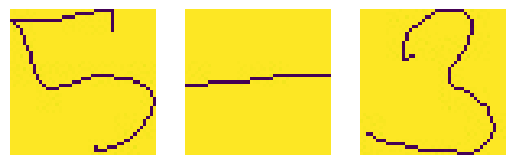

gt_pseudo_label in the 1001st data example (a list of ground truth pseudo-labels): ['5', '-', '3']
Y in the 1001st data example (the computed result): 2

X in the 3001st data example (a list of images):


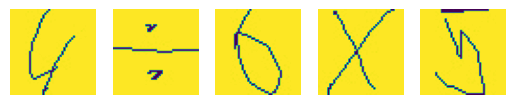

gt_pseudo_label in the 3001st data example (a list of ground truth pseudo-labels): ['4', '/', '6', '*', '5']
Y in the 3001st data example (the computed result): 3.333333333333333


In [4]:
X_1000, gt_pseudo_label_1000, Y_1000 = train_X[1000], train_gt_pseudo_label[1000], train_Y[1000]
print(f"X in the 1001st data example (a list of images):")
for i, x in enumerate(X_1000):
    plt.subplot(1, len(X_1000), i+1)
    plt.axis('off') 
    plt.imshow(x.numpy().transpose(1, 2, 0))
plt.show()
print(f"gt_pseudo_label in the 1001st data example (a list of ground truth pseudo-labels): {gt_pseudo_label_1000}")
print(f"Y in the 1001st data example (the computed result): {Y_1000}")
print()
X_3000, gt_pseudo_label_3000, Y_3000 = train_X[3000], train_gt_pseudo_label[3000], train_Y[3000]
print(f"X in the 3001st data example (a list of images):")
for i, x in enumerate(X_3000):
    plt.subplot(1, len(X_3000), i+1)
    plt.axis('off') 
    plt.imshow(x.numpy().transpose(1, 2, 0))
plt.show()
print(f"gt_pseudo_label in the 3001st data example (a list of ground truth pseudo-labels): {gt_pseudo_label_3000}")
print(f"Y in the 3001st data example (the computed result): {Y_3000}")

Note: The symbols in the HWF dataset can be one of digits or operators '+', '-', '×', '÷'. 

Note: We may see that, in the 1001st data example, the length of the formula is 3, while in the 3001st data example, the length of the formula is 5. In the HWF dataset, the length of the formula varies from 1 to 7.

## Building the Learning Part

To build the learning part, we need to first build a machine learning base model. We use SymbolNet, and encapsulate it within a `BasicNN` object to create the base model. `BasicNN` is a class that encapsulates a PyTorch model, transforming it into a base model with an sklearn-style interface. 

In [5]:
# class of symbol may be one of ['0', '1', ..., '9', '+', '-', '*', '/'], total of 14 classes
cls = SymbolNet(num_classes=14, image_size=(45, 45, 1))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cls.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

base_model = BasicNN(
    model=cls,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    batch_size=128,
    num_epochs=3,
)

`BasicNN` offers methods like `predict` and `predict_prob`, which are used to predict the class index and the probabilities of each class for images. As shown below:

In [6]:
data_instances = [torch.randn(1, 45, 45).to(device) for _ in range(32)]
pred_idx = base_model.predict(X=data_instances)
print(f"Predicted class index for a batch of 32 instances: " +
      f"{type(pred_idx).__name__} with shape {pred_idx.shape}")
pred_prob = base_model.predict_proba(X=data_instances)
print(f"Predicted class probabilities for a batch of 32 instances: " +
      f"{type(pred_prob).__name__} with shape {pred_prob.shape}")

Predicted class index for a batch of 32 instances: ndarray with shape (32,)
Predicted class probabilities for a batch of 32 instances: ndarray with shape (32, 14)


However, the base model built above deals with instance-level data (i.e., individual images), and can not directly deal with example-level data (i.e., a list of images comprising the formula). Therefore, we wrap the base model into `ABLModel`, which enables the learning part to train, test, and predict on example-level data.

In [7]:
model = ABLModel(base_model)

As an illustration, consider this example of training on example-level data using the `predict` method in `ABLModel`. In this process, the method accepts data examples as input and outputs the class labels and the probabilities of each class for all instances within these data examples.

In [8]:
from abl.structures import ListData
# ListData is a data structure provided by ABL-Package that can be used to organize data examples
data_examples = ListData()
# We use the first 1001st and 3001st data examples in the training set as an illustration
data_examples.X = [X_1000, X_3000]
data_examples.gt_pseudo_label = [gt_pseudo_label_1000, gt_pseudo_label_3000]
data_examples.Y = [Y_1000, Y_3000]

# Perform prediction on the two data examples
# Remind that, in the 1001st data example, the length of the formula is 3, 
# while in the 3001st data example, the length of the formula is 5.
pred_label, pred_prob = model.predict(data_examples)['label'], model.predict(data_examples)['prob']
print(f"Predicted class labels for the 100 data examples: a list of length {len(pred_label)}, \n" +
      f"the first element is a {type(pred_label[0]).__name__} of shape {pred_label[0].shape}, "+
      f"and the second element is a {type(pred_label[1]).__name__} of shape {pred_label[1].shape}.\n")
print(f"Predicted class probabilities for the 100 data examples: a list of length {len(pred_prob)}, \n"
      f"the first element is a {type(pred_prob[0]).__name__} of shape {pred_prob[0].shape}, " +
      f"and the second element is a {type(pred_prob[1]).__name__} of shape {pred_prob[1].shape}.")

Predicted class labels for the 100 data examples: a list of length 2, 
the first element is a ndarray of shape (3,), and the second element is a ndarray of shape (5,).

Predicted class probabilities for the 100 data examples: a list of length 2, 
the first element is a ndarray of shape (3, 14), and the second element is a ndarray of shape (5, 14).


## Building the Reasoning Part

In the reasoning part, we first build a knowledge base which contain information on how to perform addition operations. We build it by creating a subclass of `KBBase`. In the derived subclass, we initialize the `pseudo_label_list` parameter specifying list of possible pseudo-labels, and override the `logic_forward` function defining how to perform (deductive) reasoning.

In [9]:
class HwfKB(KBBase):
    def __init__(self, pseudo_label_list=["1", "2", "3", "4", "5", "6", "7", "8", "9", "+", "-", "*", "/"]):
        super().__init__(pseudo_label_list)

    def _valid_candidate(self, formula):
        if len(formula) % 2 == 0:
            return False
        for i in range(len(formula)):
            if i % 2 == 0 and formula[i] not in ["1", "2", "3", "4", "5", "6", "7", "8", "9"]:
                return False
            if i % 2 != 0 and formula[i] not in ["+", "-", "*", "/"]:
                return False
        return True
    
    # Implement the deduction function
    def logic_forward(self, formula):
        if not self._valid_candidate(formula):
            return np.inf
        return eval("".join(formula))

kb = HwfKB()

The knowledge base can perform logical reasoning (both deductive reasoning and abductive reasoning). Below is an example of performing (deductive) reasoning, and users can refer to [Documentation]() for details of abductive reasoning.

In [10]:
pseudo_label_example = ["1", "-", "2", "*", "5"]
reasoning_result = kb.logic_forward(pseudo_label_example)
print(f"Reasoning result of pseudo-label example {pseudo_label_example} is {reasoning_result}.")

Reasoning result of pseudo-label example ['1', '-', '2', '*', '5'] is -9.


Note: In addition to building a knowledge base based on `KBBase`, we can also establish a knowledge base with a ground KB using `GroundKB`. The corresponding code can be found in the `main.py` file. Those interested are encouraged to examine it for further insights.

Note: Also, when building the knowledge base, we can also set the `max_err` parameter during initialization, which is shown in the `main.py` file. This parameter specifies the upper tolerance limit when comparing the similarity between a pseudo-label example’s reasoning result and the ground truth during abductive reasoning, with a default value of 1e-10.

Then, we create a reasoner by instantiating the class ``Reasoner``. Due to the indeterminism of abductive reasoning, there could be multiple candidates compatible to the knowledge base. When this happens, reasoner can minimize inconsistencies between the knowledge base and pseudo-labels predicted by the learning part, and then return only one candidate that has the highest consistency.

In [11]:
reasoner = Reasoner(kb)

Note: During creating reasoner, the definition of "consistency" can be customized within the `dist_func` parameter. In the code above, we employ a consistency measurement based on confidence, which calculates the consistency between the data example and candidates based on the confidence derived from the predicted probability. In `main.py`, we provide options for utilizing other forms of consistency measurement.

Note: Also, during process of inconsistency minimization, we can leverage [ZOOpt library](https://github.com/polixir/ZOOpt) for acceleration. Options for this are also available in `main.py`. Those interested are encouraged to explore these features.

## Building Evaluation Metrics

Next, we set up evaluation metrics. These metrics will be used to evaluate the model performance during training and testing. Specifically, we use `SymbolMetric` and `ReasoningMetric`, which are used to evaluate the accuracy of the machine learning model’s predictions and the accuracy of the final reasoning results, respectively.

In [12]:
metric_list = [SymbolMetric(prefix="hwf"), ReasoningMetric(kb=kb, prefix="hwf")]

## Bridge Learning and Reasoning

Now, the last step is to bridge the learning and reasoning part. We proceed this step by creating an instance of `SimpleBridge`.

In [13]:
bridge = SimpleBridge(model, reasoner, metric_list)

Perform training and testing by invoking the `train` and `test` methods of `SimpleBridge`.

In [ ]:
# Build logger
print_log("Abductive Learning on the HWF example.", logger="current")
log_dir = ABLLogger.get_current_instance().log_dir
weights_dir = osp.join(log_dir, "weights")

bridge.train(train_data, train_data, loops=3, segment_size=1000, save_dir=weights_dir)
bridge.test(test_data)